In [1]:
# Run this cell if u can't mount ur drive automatically

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [2]:
# Dataset
import os
from os import makedirs, listdir
import shutil
import numpy as np

# Preprocessing
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight

#Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

now

'2024-07-17_13-58-11'

# Dataset

In [4]:
train_dir = "/content/drive/MyDrive/Mahesa/Datasets/Train"
test_dir = "/content/drive/MyDrive/Mahesa/Datasets/Test"

# train_grayscale_dir = '/content/drive/MyDrive/Mahesa/Datasets/TrainGrayScale'
# test_grayscale_dir = '/content/drive/MyDrive/Mahesa/Datasets/TestGrayScale'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [5]:
train_split = 0.8  # Proportion for training data (remaining 0.1 for validation)
val_split = 0.2  # Proportion for validation data

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=val_split,
    subset="training",
    seed=2  # Optional seed for reproducibility
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,  # Can shuffle validation data for some cases
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=val_split,
    subset="validation",
    seed=3  # Optional seed for reproducibility
)

Found 1440 files belonging to 9 classes.
Using 1152 files for training.
Found 1440 files belonging to 9 classes.
Using 288 files for validation.


In [6]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 360 files belonging to 9 classes.


# Preprocess

In [7]:
data_preprocess = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.3),
])

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.0001
initial_epochs = 10

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

# Training

## Pre Trained

In [10]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
vgg19.trainable = False

## Model

In [12]:
model_vgg19 = tf.keras.Sequential([
  data_preprocess,
  vgg19,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [ ]:
# tf.keras.utils.plot_model(model_mobilenetv2, show_shapes=True)

## Compile

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')

In [14]:
model_vgg19.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

## Train

In [15]:
history_vgg19 = model_vgg19.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks=[early_stopping])

Epoch 1/10
36/36 [==============================] - 48s 843ms/step - loss: 10.2793 - accuracy: 0.7057 - val_loss: 2.6931 - val_accuracy: 0.8611
Epoch 2/10
36/36 [==============================] - 9s 226ms/step - loss: 2.7109 - accuracy: 0.7422 - val_loss: 1.9807 - val_accuracy: 0.7882
Epoch 3/10
36/36 [==============================] - 9s 231ms/step - loss: 2.1636 - accuracy: 0.7257 - val_loss: 1.8513 - val_accuracy: 0.7986
Epoch 4/10
36/36 [==============================] - 9s 229ms/step - loss: 2.1214 - accuracy: 0.7257 - val_loss: 1.8010 - val_accuracy: 0.8194
Epoch 5/10
36/36 [==============================] - 9s 235ms/step - loss: 2.0336 - accuracy: 0.7448 - val_loss: 1.8156 - val_accuracy: 0.8021
Epoch 6/10
36/36 [==============================] - 9s 238ms/step - loss: 1.9563 - accuracy: 0.7665 - val_loss: 1.6876 - val_accuracy: 0.8125
Epoch 7/10
36/36 [==============================] - 9s 236ms/step - loss: 1.9116 - accuracy: 0.7639 - val_loss: 1.5915 - val_accuracy: 0.8507
Epoc

## Test

In [16]:
model_vgg19.evaluate(test_dataset)

12/12 [==============================] - 14s 481ms/step - loss: 1.3960 - accuracy: 0.8972


[1.3960208892822266, 0.8972222208976746]

## Graph

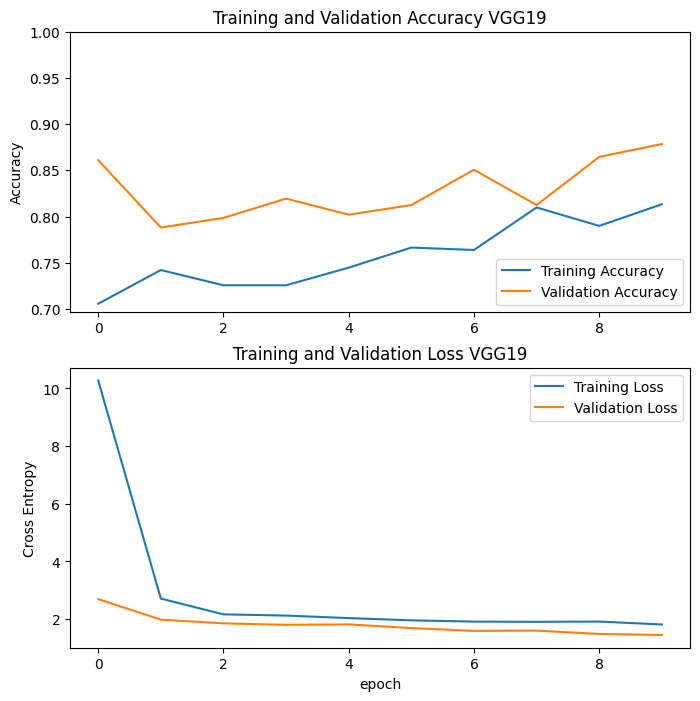

In [17]:
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']

loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy VGG19')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss VGG19')
plt.xlabel('epoch')

plt.savefig(f'/content/drive/MyDrive/Mahesa/vgg19/Graph/VGG19-82-_Accuracy_{now}.png')
plt.show()

## Matrix

In [18]:
class_labels = ['Dadar Gulung',
                'Grontol',
                'Klepon',
                'Kue Lapis',
                'Kue Lumpur',
                'Lumpia',
                'Putu Ayu',
                'Serabi',
                'Wajik']

In [19]:
y_test = []
y_pred = []


for image, label in test_dataset:
  y_pred = y_pred + model_vgg19.predict(image).argmax(axis=1).tolist()
  y_test = y_test + label.numpy().tolist()

1/1 [==============================] - 0s 157ms/step


In [ ]:
# for img, lbl, pred in zip(images, y_test, y_pred):
#   if lbl != pred:
#     print('Label :', class_labels[lbl])
#     print('Pred :', class_labels[pred])
#     plt.imshow(np.array(img).astype('uint8'))
#     plt.show()

In [ ]:
# print(y_test)
# print(y_pred)

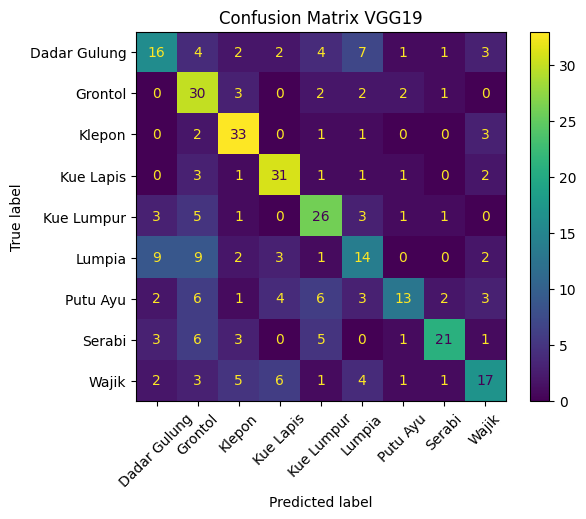

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)

disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix VGG19')
plt.savefig(f'/content/drive/MyDrive/Mahesa/vgg19/Graph/VGG19-82_Matrix_{now}.png')
plt.show()

In [21]:
# Menampilkan classification report
report = classification_report(y_test, y_pred, target_names=test_dataset.class_names)
print('Classification Report VGG19')
print(report)

# Menyimpan classification report ke dalam file teks
with open(f'/content/drive/MyDrive/Mahesa/vgg19/Graph/VGG19-82_Report_{now}.txt', 'w') as f:
    f.write('Classification Report VGG19\n')
    f.write(report)

Classification Report VGG19
              precision    recall  f1-score   support

Dadar Gulung       0.46      0.40      0.43        40
     Grontol       0.44      0.75      0.56        40
      Klepon       0.65      0.82      0.73        40
   Kue Lapis       0.67      0.78      0.72        40
  Kue Lumpur       0.55      0.65      0.60        40
      Lumpia       0.40      0.35      0.37        40
    Putu Ayu       0.65      0.33      0.43        40
      Serabi       0.78      0.53      0.63        40
       Wajik       0.55      0.42      0.48        40

    accuracy                           0.56       360
   macro avg       0.57      0.56      0.55       360
weighted avg       0.57      0.56      0.55       360



## Save Model

In [22]:
model_vgg19.save("/content/drive/MyDrive/Mahesa/vgg19/model_VGG19-82_v2.h5")

print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


In [23]:
saved_model_dir = '/content/drive/MyDrive/Mahesa/vgg19/model_VGG19-82_v2.h5'
model = tf.keras.models.load_model(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Mahesa/vgg19/model_VGG19-82_v2.tflite', 'wb') as f:
  f.write(tflite_model)

print("TFLite model saved successfully!")

TFLite model saved successfully!
